# Model based analysis of Risk and Ambiguity

Using the utility function to try and asses Risk and ambiguity aversion using the formula from 

SV = (probability − β (Ambiguity / 2)] × Value ** α 


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.special import expit

import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

load monatery data add subject sequential number starting from 0

In [2]:
db = pd.read_csv('mon.csv')
db['subn'] = db['sub'].rank(method='dense').astype(int)-1
db['subject'] = db['subn'].astype('category')
db.head()

,Unnamed: 0,choice,value,risk,ambiguity,sub,catch,subn
0,0,0.0,5,0.75,0.00,11,0.0,1
1,1,0.0,8,0.50,0.24,11,0.0,1
2,2,0.0,25,0.50,0.74,11,0.0,1
3,3,0.0,25,0.50,0.74,11,0.0,1
4,4,0.0,25,0.25,0.00,11,0.0,1


transfer values and subjects to arrays

In [4]:
value = np.asarray(db['value'])
n_subs = len(db['subn'].unique())
sub_idx = np.arange(n_subs)
n_trials = 84
 # index for trials as well
trials = np.arange(n_trials)
n_subs

51

In [5]:
# need to create matrices
valueMat = np.reshape(value, (n_subs, n_trials)).T
choiceMat = np.reshape(db.choice.values, (n_subs, n_trials)).T
riskMat = np.reshape(db.risk.values, (n_subs, n_trials)).T
ambMat = np.reshape(db.ambiguity.values, (n_subs, n_trials)).T

### model 1: risk aversion without ambiguity

In [6]:
 with pm.Model() as Risk:

    # Priors for unknown model parameters
    rMu = pm.Normal('rMu', 0,1)
    rSig = pm.Exponential('rSig', 1)
    nMu = pm.Normal('nMu', 0,1)
    nSig = pm.Exponential('nSig', 1)
    
    α = pm.Lognormal('α', rMu, rSig,  shape = n_subs)
    γ = pm.Lognormal('γ',nMu , nSig, shape = n_subs)
    
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    svLotto = (valueMat ** α[sub_idx]) * riskMat
    svRef = 5 ** α[sub_idx]
    p = (svLotto - svRef) / γ[sub_idx]
    mu =  pm.invlogit(p) #1/( 1 + np.exp(-p))
        
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=choiceMat)
    trace = pm.sample(1000, return_inferencedata=True, 
                      nuts={'target_accept':0.9})

/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in choice contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, γ, α, nSig, nMu, rSig, rMu]
>Metropolis: [choice_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
 with pm.Model() as RiskZ:

    # Priors for unknown model parameters
    
    rMu = pm.Normal('rMu', 0,.5)
    rSig = pm.Exponential('rSig', 1)
    nMu = pm.Normal('nMu', 0,.5)
    nSig = pm.Exponential('nSig', 1)

    α = pm.Lognormal('α', rMu, 1,  shape = n_subs)
    γ = pm.Lognormal('γ',nMu , 1, shape = n_subs)
    
    alpha = pm.Deterministic('alpha', 0 + α*rSig)
    gamma = pm.Deterministic('gamma', 0 + γ*nSig)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    svLotto = (valueMat**alpha[sub_idx]) * riskMat
    svRef = 5**α[sub_idx]
    p = (svLotto - svRef) /gamma[sub_idx]
    mu =  pm.invlogit(p) #1/( 1 + np.exp(-p))
    
    
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=choiceMat)
    traceZ = pm.sample(1000, return_inferencedata=True, 
                       nuts={'target_accept':0.9})

/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in choice contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, γ, α, nSig, nMu, rSig, rMu]
>Metropolis: [choice_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 182 seconds.
/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8242224825486785, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [8]:
az.summary(trace, var_names='α')[:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],0.150,0.028,0.094,0.202,0.000,0.000,3788.0,2398.0,1.0
α[1],0.742,0.060,0.629,0.855,0.001,0.001,4944.0,2579.0,1.0
α[2],0.840,0.042,0.757,0.918,0.001,0.001,3518.0,2473.0,1.0
α[3],0.802,0.036,0.727,0.864,0.001,0.000,4627.0,2020.0,1.0
α[4],0.571,0.166,0.264,0.874,0.003,0.002,3203.0,2593.0,1.0


In [9]:
az.summary(traceZ, var_names='alpha')[:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.092,0.035,0.030,0.157,0.001,0.000,3194.0,2063.0,1.00
alpha[1],0.664,0.059,0.556,0.776,0.002,0.001,981.0,1611.0,1.00
alpha[2],0.754,0.054,0.650,0.850,0.002,0.002,520.0,1489.0,1.01
alpha[3],0.722,0.047,0.632,0.810,0.002,0.001,590.0,1526.0,1.00
alpha[4],0.435,0.197,0.077,0.770,0.004,0.003,2061.0,1945.0,1.00


In [10]:
traceZ.log_likelihood.choice.mean()

<xarray.DataArray 'choice' ()>
array(-0.35569335)

In [11]:
trace.log_likelihood.choice.mean()

<xarray.DataArray 'choice' ()>
array(-0.35688642)

In [21]:
 with pm.Model() as RiskN:

    # Priors for unknown model parameters
    nMu = pm.Normal('nMu', 0,1)
    nSig = pm.Exponential('nSig', 1)
    
    a = pm.Poisson('a', 2)
    b = pm.Poisson('b', 2)
    
    α = pm.Beta('α', a, b,  shape = n_subs)
    γ = pm.Lognormal('γ',nMu , nSig, shape = n_subs)
    
    alpha = α*2
    
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    svLotto = (valueMat ** alpha[sub_idx]) * riskMat
    svRef = 5 ** alpha[sub_idx]
    p = (svLotto - svRef) / γ[sub_idx]
    mu =  pm.invlogit(p) #1/( 1 + np.exp(-p))
        
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=choiceMat)
    traceN = pm.sample(1000, return_inferencedata=True, 
                      nuts={'target_accept':0.9})

/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in choice contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, γ, α, nSig, nMu]
>CompoundStep
>>Metropolis: [choice_missing]
>>Metropolis: [b]
>>Metropolis: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [22]:
az.summary(traceN, var_names='α')[:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],0.055,0.019,0.017,0.087,0.001,0.000,1378.0,948.0,1.01
α[1],0.373,0.029,0.315,0.421,0.000,0.000,5544.0,3040.0,1.00
α[2],0.421,0.021,0.383,0.463,0.000,0.000,3741.0,2350.0,1.00
α[3],0.402,0.018,0.367,0.434,0.000,0.000,4695.0,2725.0,1.01
α[4],0.291,0.092,0.113,0.462,0.002,0.001,2134.0,1755.0,1.00


In [23]:
traceN.log_likelihood.choice.mean()

<xarray.DataArray 'choice' ()>
array(-0.35625122)

### model 2: risk and ambiguity

In [31]:
with pm.Model() as RiskAmb:
    # hyper
    rMu = pm.Normal('rMu', 0,1)
    rSig = pm.Exponential('rSig', 1)
    aMu = pm.Normal('aMu', 0,1)
    aSig = pm.Exponential('aSig', 1)
    
    nMu = pm.Normal('nMu', 0,1)
    nSig = pm.Exponential('nSig', 1)
    
    
    α = pm.Lognormal('α', rMu, rSig,  shape = n_subs)
    γ = pm.Lognormal('γ',nMu , nSig, shape = n_subs)
    # Priors for unknown model parameters
    
    β = pm.Normal('β', aMu, aSig, shape = n_subs)
    
    
   

    # Expected value of outcome
    svLotto = (valueMat ** α[sub_idx]) * (riskMat-(β[sub_idx] * (ambMat/2)))
    svRef = 5 ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=db.choice)
    choice = pm.Binomial('choice',1, mu, observed=choiceMat)
    trace2 = pm.sample(1000, return_inferencedata=True, nuts={'target_accept':0.9})

/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in choice contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [β, γ, α, nSig, nMu, aSig, aMu, rSig, rMu]
>Metropolis: [choice_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.
/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.


In [34]:
with pm.Model() as RiskAmbN:
    # hyper
    aMu = pm.Normal('aMu', 0,1)
    aSig = pm.Exponential('aSig', 1)
    
    nMu = pm.Normal('nMu', 0,1)
    nSig = pm.Exponential('nSig', 1)
    
    a = pm.Poisson('a', 2)
    b = pm.Poisson('b', 2)
    
    α = pm.Beta('α', a, b,  shape = n_subs)
    γ = pm.Lognormal('γ',nMu , nSig, shape = n_subs)
    
    alpha = α*2
    # Priors for unknown model parameters
    
    β = pm.Normal('β', aMu, aSig, shape = n_subs)
    
    # Expected value of outcome
    svLotto = (valueMat ** alpha[sub_idx]) * (riskMat-(β[sub_idx] * (ambMat/2)))
    svRef = 5 ** alpha[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=db.choice)
    choice = pm.Binomial('choice',1, mu, observed=choiceMat)
    trace2N = pm.sample(2000, return_inferencedata=True, nuts={'target_accept':0.9})

/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in choice contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [β, γ, α, nSig, nMu, aSig, aMu]
>CompoundStep
>>Metropolis: [choice_missing]
>>Metropolis: [b]
>>Metropolis: [a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 167 seconds.
/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [25]:
az.summary(trace2, var_names=['α','β'])[:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],0.157,0.030,0.098,0.216,0.000,0.000,3956.0,2842.0,1.0
α[1],0.882,0.066,0.754,1.000,0.001,0.001,3748.0,2886.0,1.0
α[2],0.994,0.066,0.882,1.118,0.001,0.001,3647.0,2567.0,1.0
α[3],0.852,0.042,0.768,0.931,0.001,0.001,3470.0,2642.0,1.0
α[4],0.599,0.162,0.289,0.888,0.003,0.002,3038.0,2512.0,1.0


In [35]:
az.summary(trace2N, var_names=['α'])[:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],0.057,0.019,0.019,0.090,0.000,0.000,4709.0,3442.0,1.0
α[1],0.443,0.034,0.380,0.508,0.000,0.000,7504.0,5361.0,1.0
α[2],0.499,0.033,0.442,0.561,0.000,0.000,7343.0,5830.0,1.0
α[3],0.427,0.021,0.386,0.467,0.000,0.000,7402.0,5490.0,1.0
α[4],0.297,0.099,0.105,0.483,0.001,0.001,4744.0,3800.0,1.0


In [36]:
az.summary(trace2N, var_names=['β'])[:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],0.450,0.513,-0.537,1.373,0.005,0.005,12110.0,5662.0,1.0
β[1],0.481,0.141,0.220,0.743,0.002,0.001,8297.0,5686.0,1.0
β[2],0.618,0.141,0.357,0.866,0.002,0.001,7140.0,6155.0,1.0
β[3],0.207,0.118,0.018,0.456,0.001,0.001,7974.0,5557.0,1.0
β[4],-0.032,0.485,-0.887,0.932,0.005,0.006,9631.0,6183.0,1.0


In [37]:
with RiskAmbN:
    ppc = pm.sample_posterior_predictive(trace2N)

In [38]:
pc = az.from_pymc3(posterior_predictive=ppc, model=RiskAmbN)
#az.plot_ppc(pc);
pc.posterior_predictive.choice.shape

(1, 8000, 84, 51)

In [137]:
pc.observed_data.choice.shape

(84, 51)

In [39]:
pp = np.mean(pc.posterior_predictive.choice.values, axis=1)
pp.shape

(1, 84, 51)

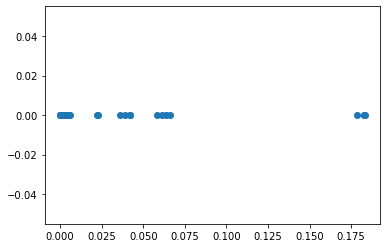

In [40]:
plt.scatter(pp[0,:,0], pc.observed_data.choice.values[:,0])